<a href="https://colab.research.google.com/github/rarespasca55-oss/Analiza_Sentimentelor/blob/main/Analiza_Sentimentelor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROIECT: Analiza Sentimentelor (Twitter US Airline)

Pasca Rares

In [4]:
import os

# Link-ul de bază către fișierele tale de pe GitHub
base_url = "https://raw.githubusercontent.com/rarespasca55-oss/Analiza_Sentimentelor/main/"
files = ["Tweets.csv", "database.sqlite", "requirements.txt", "greseli_model.csv"]

for file in files:
    if not os.path.exists(file):
        print(f"Se descarcă {file}...")
        os.system(f"wget {base_url}{file}")

# Instalarea librăriilor necesare
if os.path.exists("requirements.txt"):
    !pip install -r requirements.txt

Se descarcă database.sqlite...
Se descarcă requirements.txt...
Se descarcă greseli_model.csv...


ETAPA 1: Instalarea Librăriilor și Configurarea Mediului

In [5]:
# Instalăm librăriile
!pip install -q transformers datasets evaluate accelerate scikit-learn pyngrok streamlit
print(" Librăriile au fost instalate cu succes!")

 Librăriile au fost instalate cu succes!


ETAPA 2: Încărcarea și Curățarea Datelor

✅ Fișier încărcat: 14640 tweet-uri.


/tmp/ipython-input-2093128925.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='viridis')


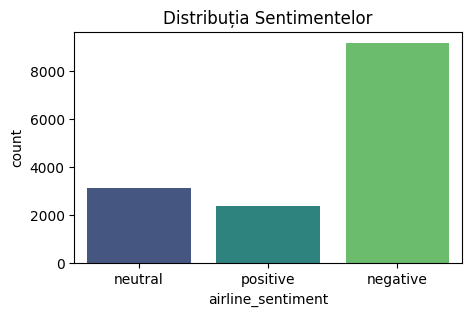

In [6]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Încărcăm datele
try:
    df = pd.read_csv('Tweets.csv')
    print(f"✅ Fișier încărcat: {len(df)} tweet-uri.")
except:
    print("❌ EROARE: Nu ai urcat fișierul Tweets.csv! Urcă-l în meniul din stânga.")

# 2. Funcția de curățare
def curata_text(text):
    text = str(text).lower()             # Litere mici
    text = re.sub(r'@\w+', '', text)     # Eliminăm @user
    text = re.sub(r'http\S+', '', text)  # Eliminăm link-uri
    text = re.sub(r'[^a-z\s]', '', text) # Păstrăm doar litere
    return text.strip()

# Aplicăm curățarea
df['text_curat'] = df['text'].apply(curata_text)

# 3. Vizualizare Distribuție (pentru documentație)
plt.figure(figsize=(5, 3))
sns.countplot(x='airline_sentiment', data=df, palette='viridis')
plt.title('Distribuția Sentimentelor')
plt.show()

ETAPA 3: Pregătirea Datelor pentru BERT (Tokenizare)

In [7]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer

# 1. Mapăm etichetele text -> numere
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['label'] = df['airline_sentiment'].map(label_map)

# 2. Pregătim seturile de date
df_bert = df[['text_curat', 'label']].dropna()
train_df, test_df = train_test_split(df_bert, test_size=0.2, random_state=42)

# 3. Convertim la format Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 4. Tokenizare
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text_curat"], truncation=True, padding=True, max_length=128)

encoded_train = train_dataset.map(preprocess_function, batched=True)
encoded_test = test_dataset.map(preprocess_function, batched=True)

print(" Datele sunt pregătite pentru AI.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/11712 [00:00<?, ? examples/s]

Map:   0%|          | 0/2928 [00:00<?, ? examples/s]

 Datele sunt pregătite pentru AI.


ETAPA 4: Antrenarea Modelului (Fine-Tuning)

In [8]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

# Metrica de acuratețe
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Modelul
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label_map
)

# Setările antrenamentului
training_args = TrainingArguments(
    output_dir="my_airline_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

# Antrenorul
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("🚀 Începe antrenarea... Te rog așteaptă.")
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2305771031.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Începe antrenarea... Te rog așteaptă.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.566800,0.424705,0.828210
2,0.417100,0.437526,0.837090


TrainOutput(global_step=1464, training_loss=0.4437170497706679, metrics={'train_runtime': 152.5502, 'train_samples_per_second': 153.549, 'train_steps_per_second': 9.597, 'total_flos': 253050360996096.0, 'train_loss': 0.4437170497706679, 'epoch': 2.0})

PASUL 5: Evaluare și Analiza Erorilor

In [9]:
from sklearn.metrics import classification_report

# 1. Facem predicții pe test
preds_output = trainer.predict(encoded_test)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# 2. Afișăm Raportul (pentru documentație)
print("\nRAPORT FINAL DE PERFORMANȚĂ:")
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

# 3. Analiza Erorilor (Generăm CSV pentru site)
df_errors = test_df.copy().reset_index(drop=True)
df_errors['Real'] = y_true
df_errors['Prezis'] = y_pred
df_errors = df_errors[df_errors['Real'] != df_errors['Prezis']] # Păstrăm doar greșelile

# Mapăm înapoi la text
df_errors['Real_Text'] = df_errors['Real'].map(id2label)
df_errors['Prezis_Text'] = df_errors['Prezis'].map(id2label)

# Salvăm fișierul pentru site
df_errors.to_csv('greseli_model.csv', index=False)
print(" Fișierul 'greseli_model.csv' a fost generat pentru Modul Debug al site-ului.")


RAPORT FINAL DE PERFORMANȚĂ:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      1889
     neutral       0.63      0.67      0.65       580
    positive       0.80      0.77      0.78       459

    accuracy                           0.83      2928
   macro avg       0.78      0.78      0.78      2928
weighted avg       0.83      0.83      0.83      2928

 Fișierul 'greseli_model.csv' a fost generat pentru Modul Debug al site-ului.


ETAPA 6: Salvarea Modelului Final

In [10]:
trainer.save_model("./model_final_salvat")
tokenizer.save_pretrained("./model_final_salvat")
print(" Model salvat pe disk.")

 Model salvat pe disk.


ETAPA 7: Crearea și Lansarea Site-ului (Streamlit + Ngrok)

Pasul 7.1: Scriem fișierul app.py

In [11]:
%%writefile app.py
import streamlit as st
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- CONFIGURARE ---
st.set_page_config(page_title="Analiză Sentimente AI", page_icon="✈️", layout="wide")

# --- MODEL ---
@st.cache_resource
def incarca_model():
    return pipeline("sentiment-analysis", model="./model_final_salvat")

try:
    classifier = incarca_model()
except:
    st.error("Modelul nu a fost găsit! Asigură-te că ai rulat Pasul 6.")
    st.stop()

# --- DATE ---
@st.cache_data
def incarca_date():
    try:
        df = pd.read_csv('Tweets.csv')
        # Convertim coloana de timp pentru grafice
        if 'tweet_created' in df.columns:
            df['tweet_created'] = pd.to_datetime(df['tweet_created'])

        try:
            erori = pd.read_csv('greseli_model.csv')
        except:
            erori = None
        return df, erori
    except:
        return None, None

df, df_erori = incarca_date()

# --- SIDEBAR (STATISTICI AVANSATE) ---
st.sidebar.title("🛠️ Panou Control")

if df is not None:
    st.sidebar.subheader("1. Distribuție Totală")
    counts = df['airline_sentiment'].value_counts()
    fig1, ax1 = plt.subplots(figsize=(4,3))
    ax1.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
    st.sidebar.pyplot(fig1)

    # --- CERINȚA: GRAFIC ÎN TIMP ---
    if 'tweet_created' in df.columns:
        st.sidebar.subheader("2. Evoluție în Timp")
        # Grupăm datele pe zile
        daily = df.groupby([df['tweet_created'].dt.date, 'airline_sentiment']).size().unstack()
        st.sidebar.line_chart(daily)

    # --- BONUS: COMPARATIE COMPANII ---
    if 'airline' in df.columns:
        st.sidebar.subheader("3. Top Companii Aeriene")
        # Numărăm sentimentele per companie
        fig2, ax2 = plt.subplots(figsize=(5,3))
        sns.countplot(y='airline', hue='airline_sentiment', data=df, palette='viridis', ax=ax2)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        st.sidebar.pyplot(fig2)
        st.sidebar.caption("Compară care companie are cele mai multe plângeri.")

st.sidebar.divider()
arata_erori = st.sidebar.checkbox("🔍 Arată Analiza Erorilor", help="Vezi unde a greșit AI-ul.")

# --- LOGICĂ INTERFAȚĂ ---
if 'text_curent' not in st.session_state:
    st.session_state.text_curent = ""

def genereaza_exemplu():
    if df is not None:
        st.session_state.text_curent = random.choice(df['text'].tolist())

# --- AFIȘARE PRINCIPALĂ ---
if arata_erori and df_erori is not None:
    st.title("📉 Analiza Erorilor (Debug Mode)")
    st.info("Exemple unde AI-ul a clasificat greșit (posibil sarcasm sau ambiguitate).")
    st.dataframe(df_erori[['text_curat', 'Real_Text', 'Prezis_Text']].head(50), use_container_width=True)
else:
    st.title("✈️ Analiza Sentimentelor - Linii Aeriene")
    st.markdown("Proiect AI pentru detectarea automată a opiniilor pasagerilor.")

    c1, c2 = st.columns([3, 1])
    with c1:
        user_input = st.text_area("Mesaj (Engleză):", key="text_curent", height=100)
    with c2:
        st.write("")
        st.write("")
        st.button("🎲 Generează Exemplu", on_click=genereaza_exemplu)

    if st.button("🔍 Analizează", type="primary"):
        if user_input:
            res = classifier(user_input)[0]
            label = res['label']
            score = res['score']

            mapare = {
                'LABEL_0': ('NEGATIV', '😠', 'error'), 'negative': ('NEGATIV', '😠', 'error'),
                'LABEL_1': ('NEUTRU', '😐', 'warning'), 'neutral': ('NEUTRU', '😐', 'warning'),
                'LABEL_2': ('POZITIV', '😃', 'success'), 'positive': ('POZITIV', '😃', 'success')
            }
            text, icon, color = mapare.get(label, (label, '', 'info'))

            st.divider()
            col_a, col_b = st.columns(2)
            col_a.metric("Sentiment Detectat", f"{text} {icon}")
            col_b.write(f"Încredere: {score:.2%}")
            col_b.progress(score)

            if text == 'NEGATIV': st.error("Prioritate: RIDICATĂ")
            elif text == 'POZITIV': st.success("Client Mulțumit")
            else: st.warning("Neutru")

Writing app.py


Pasul 7.2: Pornim Site-ul cu Ngrok

In [12]:
from pyngrok import ngrok

# Token-ul tău (deja configurat)
ngrok.set_auth_token("36hKJnkS850MbNOLxN5ht2SyWAb_2RqCzobQh54Mo5oGCk8zP")

# Oprim procesele vechi
!pkill -9 -f streamlit

# Pornim tunelul
try:
    url = ngrok.connect(8501).public_url
    print(f" SITE-UL TĂU ESTE AICI (Click pe el): {url}")
except:
    print("⚠️ Eroare la conectare. Verifică token-ul sau restartează Runtime-ul.")

# Rulăm aplicația
!streamlit run app.py &>/dev/null&

 SITE-UL TĂU ESTE AICI (Click pe el): https://tatyana-unstudied-beatriz.ngrok-free.dev


Crearea fișierului requirements.txt

In [13]:
%%writefile requirements.txt
transformers
torch
pandas
numpy
scikit-learn
streamlit
pyngrok
matplotlib
seaborn
evaluate
accelerate
datasets

Writing requirements.txt


Crearea fișierului README.md

In [14]:
%%writefile README.md
# Proiect: Analiza Sentimentelor în Social Media (Twitter Airline)

Acest proiect utilizează un model de Deep Learning (DistilBERT) pentru a analiza sentimentele (Pozitiv, Negativ, Neutru) din tweet-uri despre companii aeriene.

## Structura Proiectului
* **app.py** - Codul principal al aplicației web (Streamlit).
* **Tweets.csv** - Setul de date utilizat pentru analiză.
* **greseli_model.csv** - Fișier generat automat care conține exemplele unde modelul a greșit (pentru Analiza Erorilor).
* **requirements.txt** - Lista librăriilor necesare.
* **Analiza_Sentimentelor.ipynb** - Notebook-ul cu antrenarea modelului și analiza datelor.

## Cum se rulează proiectul

### Varianta 1: Google Colab (Recomandat)
1. Deschideți fișierul `.ipynb` în Google Colab.
2. Încărcați fișierul `Tweets.csv` în sesiunea Colab.
3. Rulați toate celulele în ordine.
4. Accesați link-ul generat de Ngrok pentru a deschide interfața grafică.

### Varianta 2: Local (Pe PC)
1. Instalați librăriile: `pip install -r requirements.txt`
2. Rulați aplicația: `streamlit run app.py`

## Funcționalități
* Clasificare text liber (Engleză).
* Generare exemple aleatorii din dataset.
* Vizualizare grafică a distribuției sentimentelor.
* **Modul de Debugging**: Afișarea și analiza erorilor de predicție (bazat pe `greseli_model.csv`).

Writing README.md


Crearea Arhivei ZIP pentru descărcare

In [15]:
import zipfile
import os
from google.colab import files

print("📦 Se creează arhiva ZIP finală...")

nume_arhiva = "Proiect_Analiza_Sentimente_Final.zip"

with zipfile.ZipFile(nume_arhiva, 'w') as zipf:
    zipf.write("app.py")
    zipf.write("requirements.txt")
    zipf.write("README.md")

    # Verificăm și adăugăm fișierul de greșeli
    if os.path.exists("greseli_model.csv"):
        zipf.write("greseli_model.csv")
        print("✅ Am inclus și fișierul 'greseli_model.csv' în arhivă.")
    else:
        print("⚠️ Atenție: Nu am găsit 'greseli_model.csv'. Asigură-te că ai rulat pasul de analiză a erorilor.")

print(f"🎉 Gata! Descarcă '{nume_arhiva}'.")
files.download(nume_arhiva)

📦 Se creează arhiva ZIP finală...
✅ Am inclus și fișierul 'greseli_model.csv' în arhivă.
🎉 Gata! Descarcă 'Proiect_Analiza_Sentimente_Final.zip'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>